<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [99]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

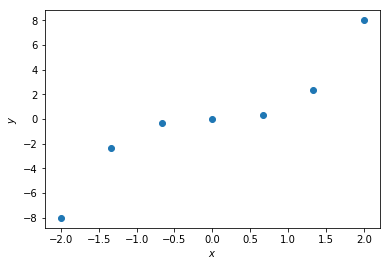

In [4]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [5]:
import random as rnd
X_test = np.linspace(-2, 2, 200)

In [91]:
def predict(X_test, X, y, *thresholds):
    if not thresholds: return [y.mean() for i in X_test]
    return [y[threshold(X)].mean() for value in X_test for threshold in thresholds if threshold(value)]

In [92]:
a = lambda x: x>=0

In [93]:
y[a(X)].mean()

2.666666666666666

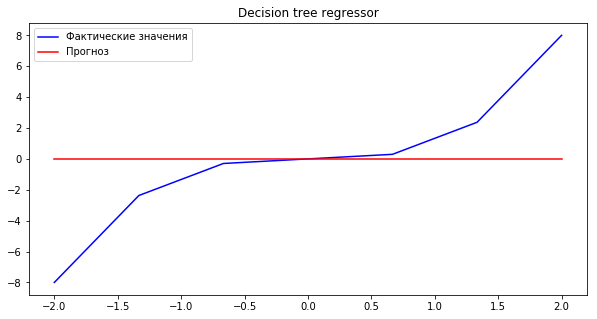

In [94]:
import random as rnd
plt.figure(figsize=(10, 5))
plt.plot(X, y, 'b', label='Фактические значения')
plt.plot(X_test, 
         predict(X_test, X, y), 
         'r', label='Прогноз')
plt.title("Decision tree regressor")
plt.legend()
plt.show()

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

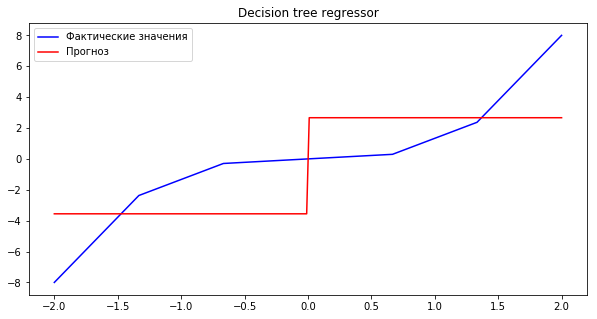

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(X, y, 'b', label='Фактические значения')
plt.plot(X_test, predict(X_test.reshape(-1,1), X, y, lambda x: x<0, lambda x: x>=0), 'r', label='Прогноз')
plt.title("Decision tree regressor")
plt.legend()
plt.show() 

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [96]:
def Q(X, t):
    Xl = X[X <  t]
    Xr = X[X >= t]
    return np.var(y) - np.var(y[X < t])*Xl.shape[0]/X.shape[0] - np.var(y[X >= t])*Xr.shape[0]/X.shape[0]

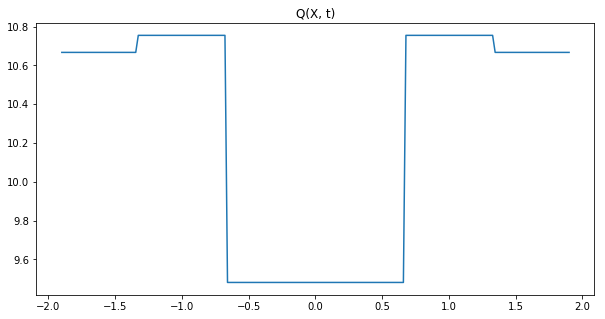

In [97]:
T = np.linspace(-1.9, 1.9, 200)
Y = [Q(X, t) for t in T]

plt.figure(figsize=(10, 5))
plt.plot(T, Y)
plt.title("Q(X, t)")
plt.show()

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- <font color='green'>Нет</font>

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [110]:
X_test[(X_test)>0  & (X_test > 10)]

array([0.01005025, 0.03015075, 0.05025126, 0.07035176, 0.09045226,
       0.11055276, 0.13065327, 0.15075377, 0.17085427, 0.19095477,
       0.21105528, 0.23115578, 0.25125628, 0.27135678, 0.29145729,
       0.31155779, 0.33165829, 0.35175879, 0.3718593 , 0.3919598 ,
       0.4120603 , 0.4321608 , 0.45226131, 0.47236181, 0.49246231,
       0.51256281, 0.53266332, 0.55276382, 0.57286432, 0.59296482,
       0.61306533, 0.63316583, 0.65326633, 0.67336683, 0.69346734,
       0.71356784, 0.73366834, 0.75376884, 0.77386935, 0.79396985,
       0.81407035, 0.83417085, 0.85427136, 0.87437186, 0.89447236,
       0.91457286, 0.93467337, 0.95477387, 0.97487437, 0.99497487,
       1.01507538, 1.03517588, 1.05527638, 1.07537688, 1.09547739,
       1.11557789, 1.13567839, 1.15577889, 1.1758794 , 1.1959799 ,
       1.2160804 , 1.2361809 , 1.25628141, 1.27638191, 1.29648241,
       1.31658291, 1.33668342, 1.35678392, 1.37688442, 1.39698492,
       1.41708543, 1.43718593, 1.45728643, 1.47738693, 1.49748

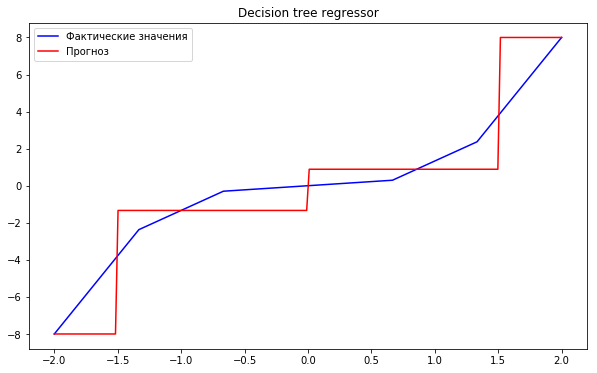

In [111]:
import random as rnd
X_test = np.linspace(-2, 2, 200)

plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b', label='Фактические значения')
plt.plot(X_test, predict(X_test, X, y, 
                                 lambda x: x < -1.5,
                                 lambda x: (-1.5 <= x) & (x < 0),
                                 lambda x: (0 <= x) & (x < 1.5),
                                 lambda x: x > 1.5), 'r', label='Прогноз')
plt.title("Decision tree regressor")
plt.legend()
plt.show()

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <font color='green'>7</font>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [112]:
df = pd.read_csv('../../mlcourse_open/data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [113]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [114]:
df['age_years'] = (df.age // 365.25).astype(int)

In [115]:
df = pd.concat([df, pd.get_dummies(df.gluc, prefix='gluc'),
                pd.get_dummies(df.cholesterol, prefix='cholesterol')], axis=1)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [116]:
X_train, X_valid, y_train, y_valid = train_test_split(df, df.cardio, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [117]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
column_names = ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 
                  'alco', 'active', 'age_years', 'gluc_1', 'gluc_2', 
                  'gluc_3', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3']
tree.fit(X_train[column_names].values, y_train.values)
export_graphviz(tree, out_file='tree.dot', filled=True,
               feature_names=column_names)
!dot -Tpng 'tree.dot' -o 'tree.png'

<img src='tree.png' width=100%>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <font color='green'>age, ap_hi, chol=3</font>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [119]:
tree_predict = tree.predict(X_valid[column_names])
accuracy_score_before = accuracy_score(y_valid, tree_predict)
accuracy_score_before

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [120]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5)
tree_grid.fit(X_train[column_names], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

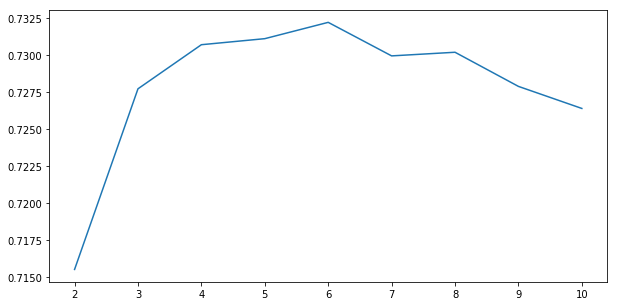

In [121]:
import warnings
warnings.filterwarnings('ignore')

depths = [grid_score[0]['max_depth'] for grid_score in tree_grid.grid_scores_]
scores = [grid_score[1] for grid_score in tree_grid.grid_scores_]

plt.figure(figsize=(10, 5))
plt.plot(depths, scores)
plt.show()

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [122]:
tree_grid.best_score_, tree_grid.best_params_

(0.732204081632653, {'max_depth': 6})

In [125]:
predict = tree_grid.predict(X_valid[column_names])
accuracy_score_after = accuracy_score(y_valid, predict)
accuracy_score_after

0.7256666666666667

In [127]:
(accuracy_score_after - accuracy_score_before)/accuracy_score_after*100

0.6037141544720773

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- <font color='green'>да, нет</font>
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='https://habrastorage.org/webt/gg/38/vf/gg38vfl5ql8obqjmlsvt9es76p8.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- <font color='green'>Верхнее артериальное давление от 140 до 160 (мм рт.ст.)</font>
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [358]:
df['age_45_50'] = df.age_years.apply(lambda x: (0, 1)[45 <= x < 50])
df['age_50_55'] = df.age_years.apply(lambda x: (0, 1)[50 <= x < 55])
df['age_55_60'] = df.age_years.apply(lambda x: (0, 1)[55 <= x < 60])
df['age_60_65'] = df.age_years.apply(lambda x: (0, 1)[60 <= x < 65])

df['ap_hi_120_140'] = df.ap_hi.apply(lambda x: (0, 1)[120 <= x < 140])
df['ap_hi_140_160'] = df.ap_hi.apply(lambda x: (0, 1)[140 <= x < 160])
df['ap_hi_160_180'] = df.ap_hi.apply(lambda x: (0, 1)[160 <= x < 180])

In [364]:
df.gender = df.gender.map({1: 0, 2: 1})

In [370]:
column_names = ['gender', 'smoke', 'age_45_50', 'age_50_55', 'age_55_60', 'age_60_65', 'ap_hi_120_140', 
                'ap_hi_140_160', 'ap_hi_160_180', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3']

In [373]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(df[column_names], df.cardio)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [375]:
export_graphviz(tree, out_file='tree2.dot', filled=True,
               feature_names=column_names)
!dot -Tpng 'tree2.dot' -o 'tree2.png'

<img src='tree2.png' width=100%>